In [1]:
import pandas as pd
import geopandas as gpd
from blocksnet import City

blocks = gpd.read_parquet('./data/blocks_cutter_result.parquet')
blocks.head()

,geometry,id,landuse
index,,,
0,"POLYGON ((345370.504 6646430.885, 345370.505 6...",0,no_dev_area
1,"POLYGON ((345254.667 6647047.217, 345254.667 6...",1,buildings
2,"POLYGON ((345055.642 6646758.330, 345055.643 6...",2,selected_area
3,"POLYGON ((344966.092 6647146.023, 344966.091 6...",3,no_dev_area
4,"POLYGON ((345082.562 6646776.418, 345082.561 6...",4,buildings


In [2]:
from blocksnet import GraphGenerator, AdjacencyCalculator

graph = GraphGenerator(territory=blocks).get_graph('walk')
adj_mx = AdjacencyCalculator(blocks=blocks, graph=graph).get_dataframe()
city = City(blocks_gdf=blocks, adjacency_matrix=adj_mx)

buildings = gpd.read_parquet('./data/buildings.parquet')
buildings = buildings.rename(columns={
  'population_balanced': 'population',
  'total_area': 'area',
})
buildings['floors'] = 1
city.update_buildings(buildings)

Graph made for 'walk' network type


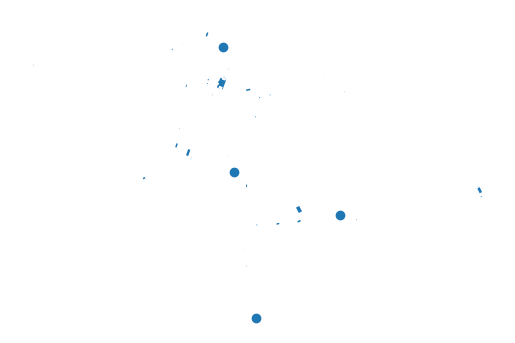

In [3]:
import osmnx as ox

polygon = blocks.to_crs(4326).unary_union.convex_hull
osm_services = ox.features_from_polygon(polygon=polygon, tags={'leisure':'pitch'}).to_crs(city.epsg).reset_index()[['geometry']]
osm_services.plot().set_axis_off()

In [4]:
from blocksnet.preprocessing.capacity_filler import CapacityFiller

service_type = city['pitch']
cf = CapacityFiller(
  services=osm_services, 
  service_type=city['pitch'], 
  is_osm=True
)

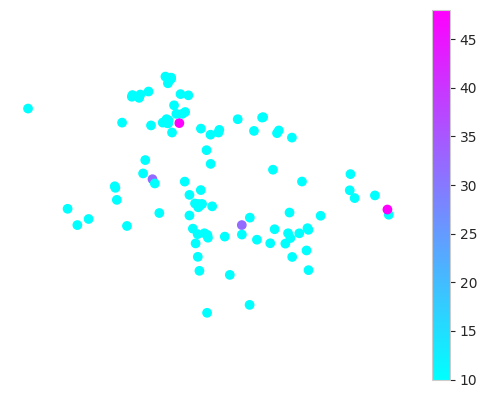

In [7]:
filled_services = cf.fill()
city.update_services(service_type, filled_services)
filled_services.plot(column='capacity', legend=True, cmap='cool').set_axis_off()

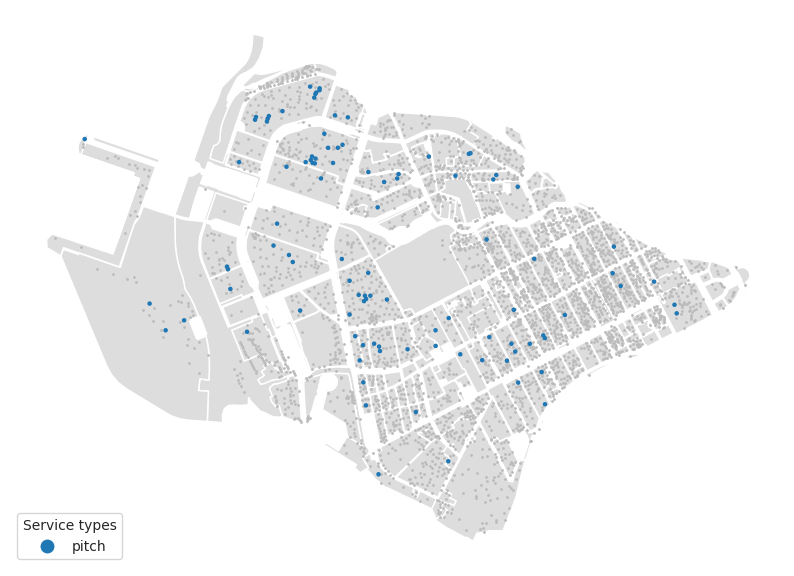

In [8]:
city.plot()

<Axes: title={'center': 'Provision:  0.522'}>

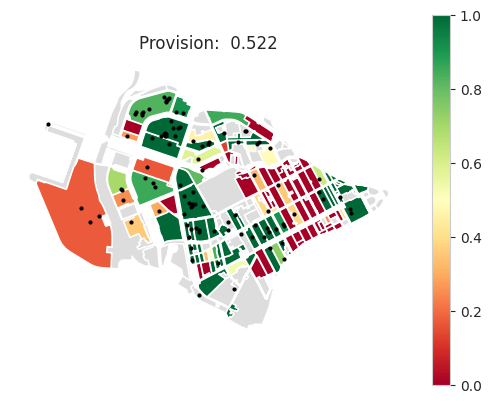

In [16]:
from blocksnet import Provision

prov = Provision(city_model=city)
calc, _ = prov.calculate(service_type, method='gravity')
ax = prov.plot(calc)
filled_services.plot(ax=ax, markersize=4, color='#000')